In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.dataloading import DataLoader
from src.preprocessing import Preprocesser
from src.vae_lstm import LSTMVAE
from src.vae_dense import DenseVAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [68]:
LATENT_DIM: int = 10

# Load Data

In [69]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2023-12-19 18:07:19,914 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2023-12-19 18:07:36,154 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


# Preprocess Data

In [70]:
preprocessor_train = Preprocesser(df_list=df_list, condition="MathxHard", rolling_window_size=250, fixed_size=10990)
tensor: np.array = preprocessor_train.preprocess_data()
FEATURE_NAMES = list(preprocessor_train.df_list_processed[0].columns)

print(tensor.shape)

2023-12-19 18:07:36,445 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Window Size: 250, Fixed Size: 10990) ...
2023-12-19 18:07:36,611 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2023-12-19 18:07:36,615 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.17s) ...


(430, 250, 7)


# Modelling

In [71]:
#vae = LSTMVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=3)
vae = DenseVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=3)
vae.compile(optimizer="adam")
vae.build((None, tensor.shape[1], tensor.shape[2]))

In [72]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 250, 7)]             0         []                            
                                                                                                  
 flatten_2 (Flatten)         (None, 1750)                 0         ['input_5[0][0]']             
                                                                                                  
 dense_18 (Dense)            (None, 256)                  448256    ['flatten_2[0][0]']           
                                                                                                  
 dense_19 (Dense)            (None, 128)                  32896     ['dense_18[0][0]']            
                                                                                            

In [73]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_23 (Dense)            (None, 16)                176       
                                                                 
 dense_24 (Dense)            (None, 32)                544       
                                                                 
 dense_25 (Dense)            (None, 64)                2112      
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 decoder_final_dense (Dense  (None, 1750)              225750    
 )                                                               
                                                           

In [74]:
history = vae.fit(tensor, epochs=256, batch_size=8, validation_split=0.2, shuffle=True
                  )#,callbacks=[ReduceLROnPlateau(monitor="val_loss", patience=15), EarlyStopping(monitor="val_loss", patience=20)]


Epoch 1/256
43/43 [==============================] - 3s 10ms/step - loss: 937.1901 - reconstruction_loss: 150.6252 - kl_loss: 24.7479 - val_loss: 248.3544 - val_reconstruction_loss: 35.2829 - val_kl_loss: 142.5057
Epoch 2/256
43/43 [==============================] - 0s 6ms/step - loss: 119.2462 - reconstruction_loss: 31.2592 - kl_loss: 20.9189 - val_loss: 243.9400 - val_reconstruction_loss: 30.9272 - val_kl_loss: 151.1583
Epoch 3/256
43/43 [==============================] - 0s 5ms/step - loss: 114.7125 - reconstruction_loss: 29.2787 - kl_loss: 20.8134 - val_loss: 237.7536 - val_reconstruction_loss: 31.1322 - val_kl_loss: 144.3570
Epoch 4/256
43/43 [==============================] - 0s 7ms/step - loss: 110.2018 - reconstruction_loss: 29.7340 - kl_loss: 18.6063 - val_loss: 201.1861 - val_reconstruction_loss: 28.9160 - val_kl_loss: 114.4380
Epoch 5/256
43/43 [==============================] - 0s 6ms/step - loss: 97.5083 - reconstruction_loss: 27.2817 - kl_loss: 17.2850 - val_loss: 193.180

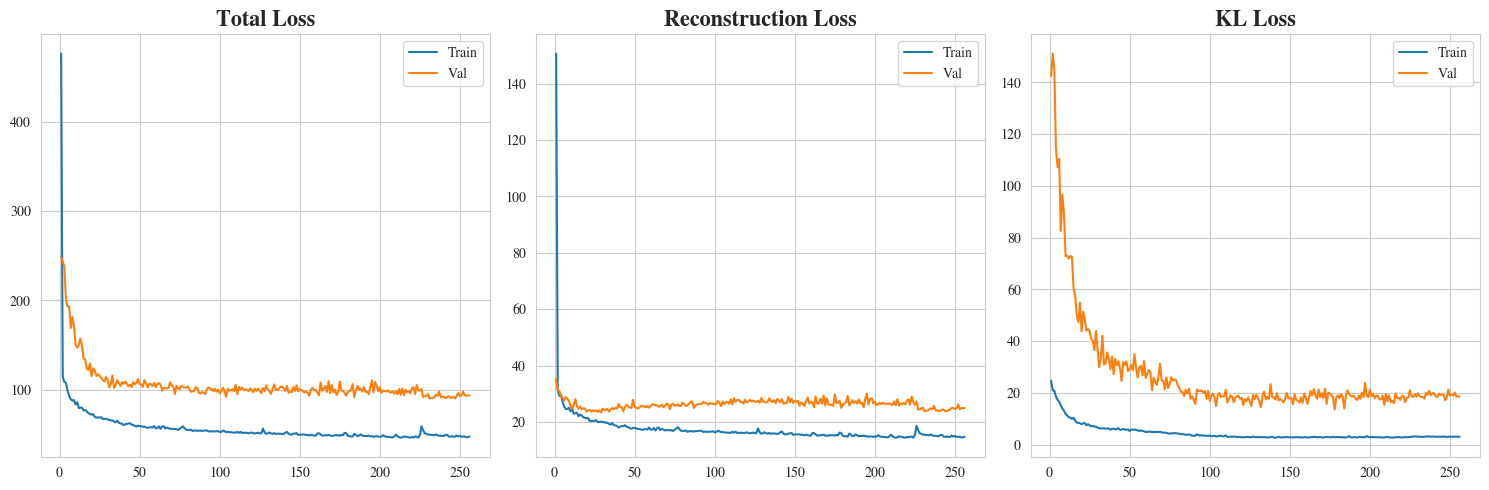

In [75]:
def plot_history(history):
    loss_dict = history.history

    loss_train = loss_dict["loss"]
    loss_val = loss_dict["val_loss"]

    rec_loss = loss_dict["reconstruction_loss"]
    rec_loss_val = loss_dict["val_reconstruction_loss"]

    kl_loss = loss_dict["kl_loss"]
    kl_loss_val = loss_dict["val_kl_loss"]

    x = [i+1 for i in range(0, len(loss_train))]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axes[0].set_title("Total Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=loss_train, label="Train", ax=axes[0])
    sns.lineplot(x=x, y=loss_val, label="Val", ax=axes[0])

    axes[1].set_title("Reconstruction Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=rec_loss, label="Train", ax=axes[1])
    sns.lineplot(x=x, y=rec_loss_val, label="Val", ax=axes[1])

    axes[2].set_title("KL Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=kl_loss, label="Train", ax=axes[2])
    sns.lineplot(x=x, y=kl_loss_val, label="Val", ax=axes[2])
    fig.tight_layout()

plot_history(history)

## Save Model

In [76]:
#vae.save("../models/e64_b2_43k_params")

# Load Model
#vae = tf.keras.models.load_model("../models/e32-b1_final_dir")

# Reconstruction Plotting

In [77]:
train_sample = np.expand_dims(tensor[0], axis=0)
print(train_sample.shape)

(1, 250, 7)


In [78]:
train_sample_reconstructed = vae.predict(train_sample)

1/1 [==============================] - 0s 130ms/step


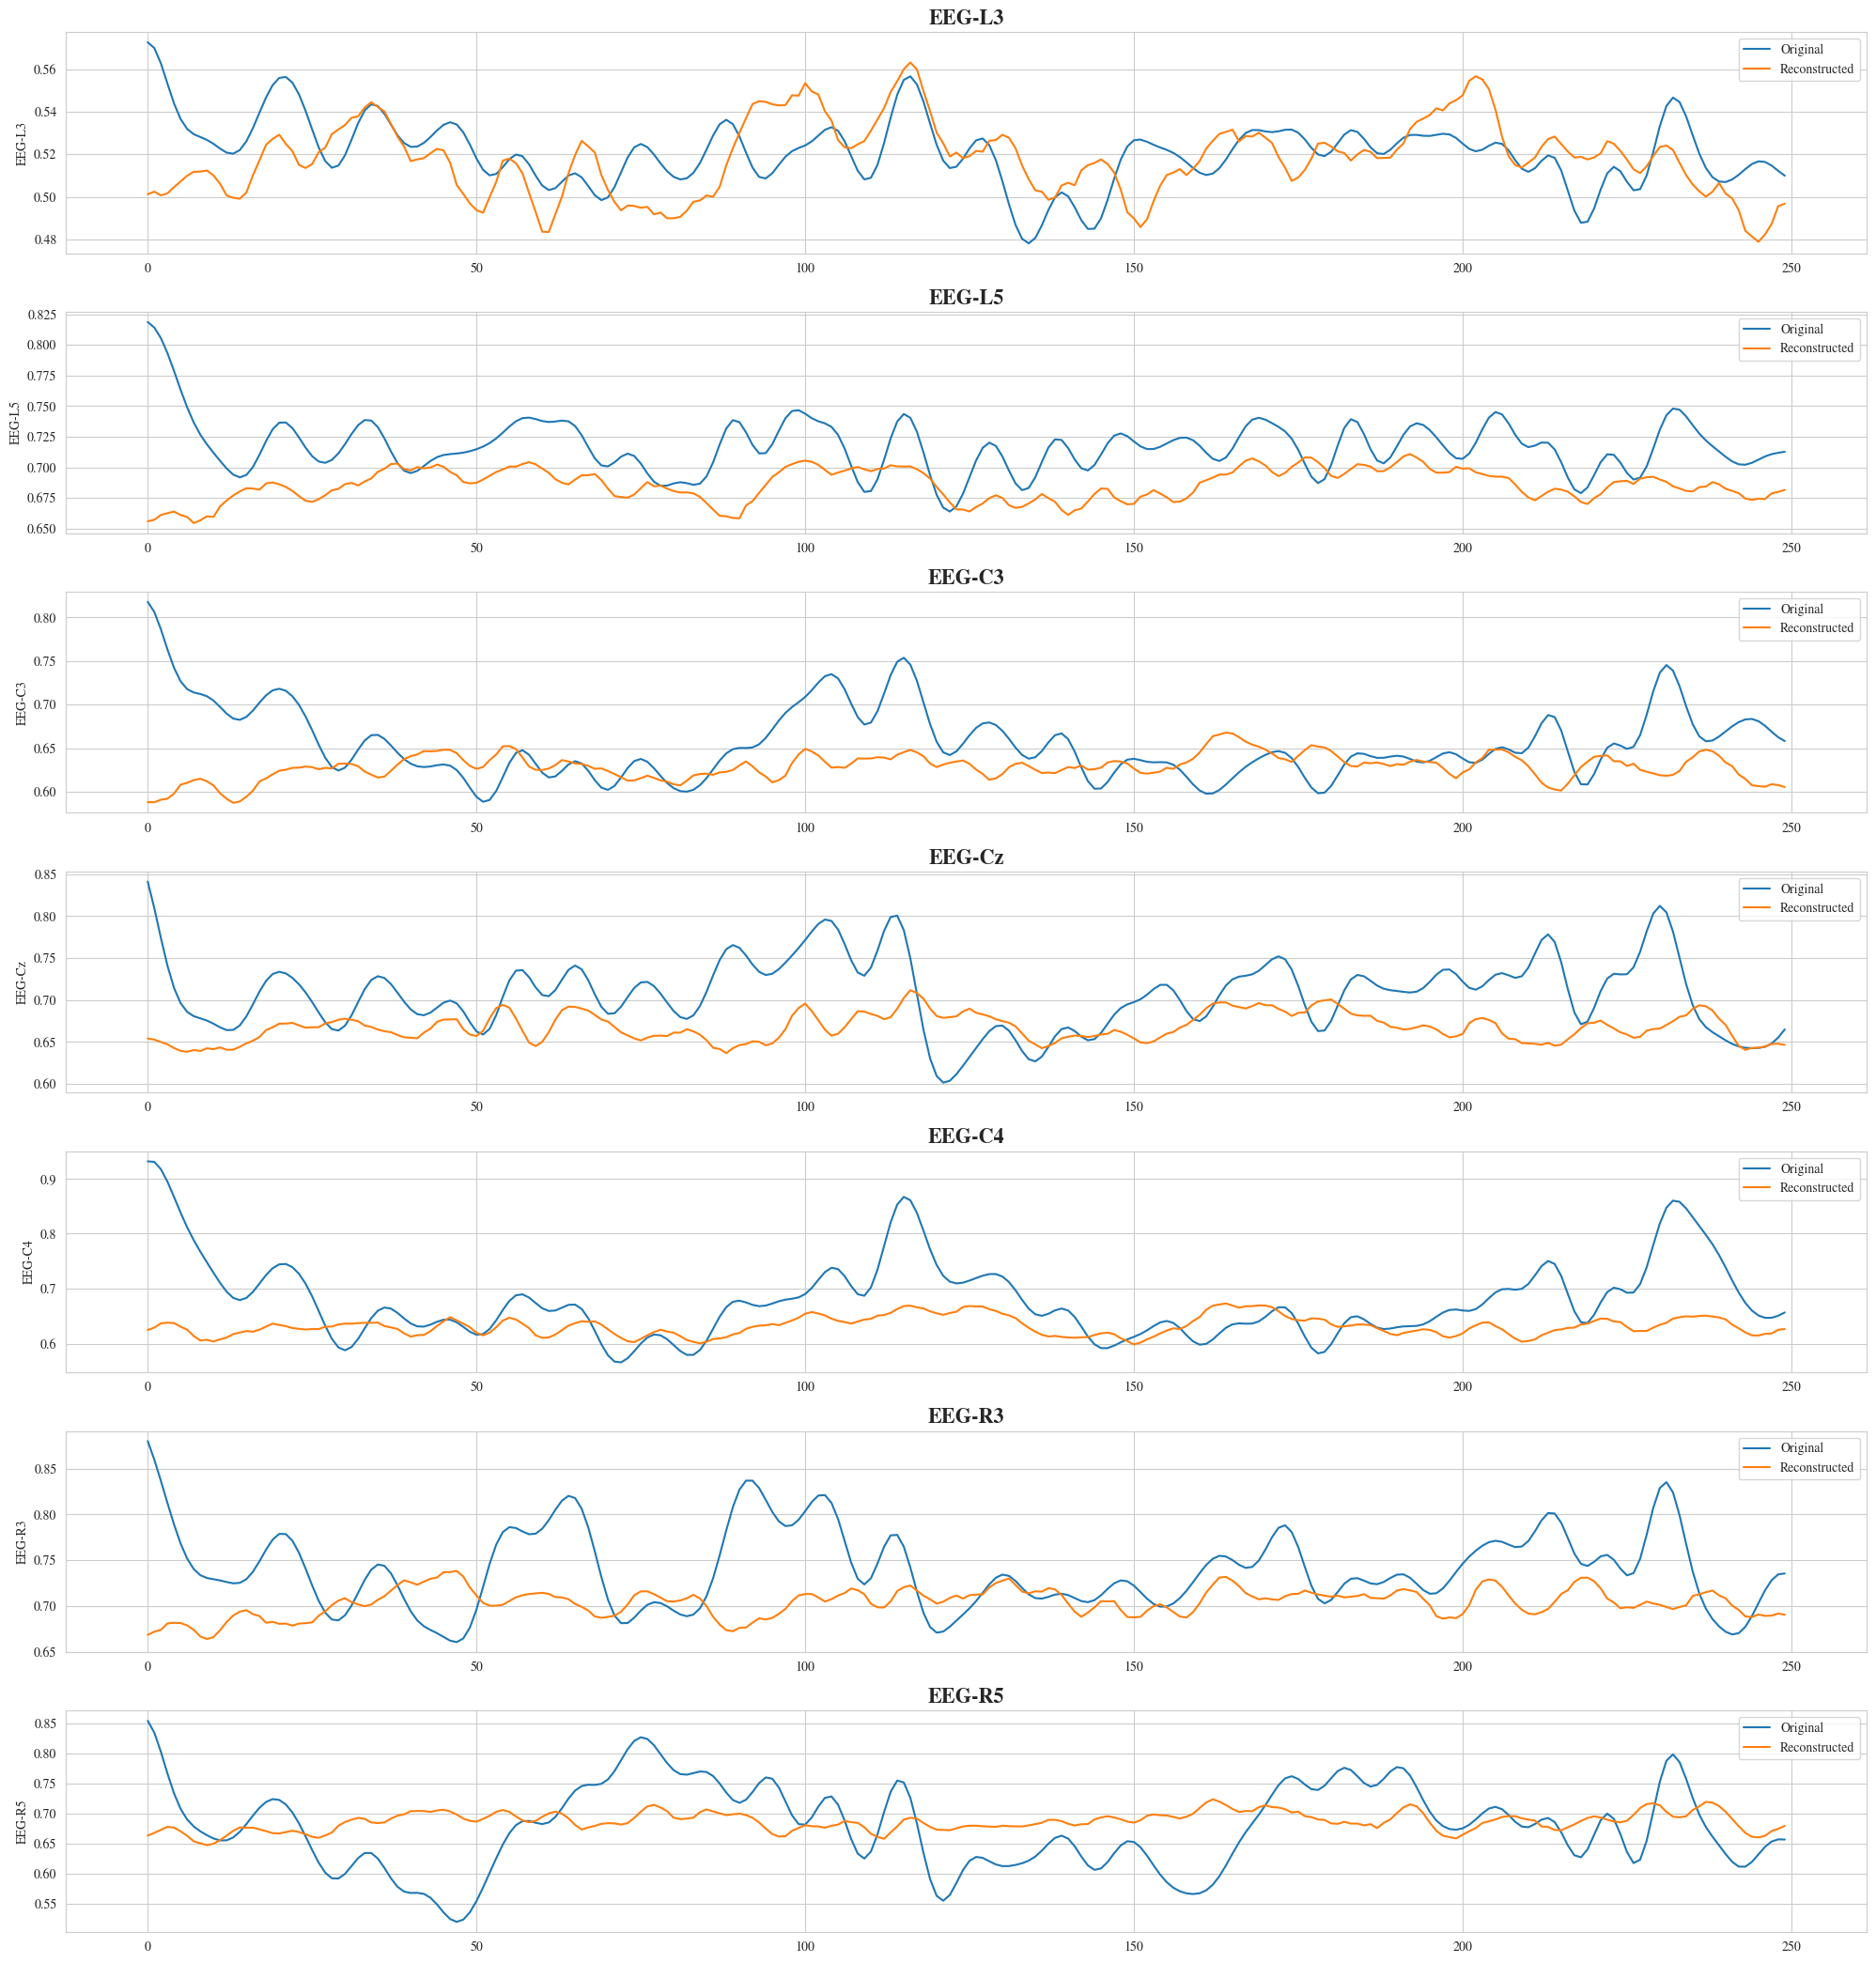

In [79]:
# Compare original and reconstruction
def compare_original_and_reconstruction(sample: np.array, sample_reconstructed: np.array) -> None:
    df_sample = pd.DataFrame(sample, columns=FEATURE_NAMES)
    df_reconstructed = pd.DataFrame(sample_reconstructed, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(FEATURE_NAMES), ncols=1, figsize=(20, len(FEATURE_NAMES)*3))
    for col, ax in zip(FEATURE_NAMES, axes.flatten()):
        sns.lineplot(data=df_sample, x=df_sample.index, y=col, ax=ax, label="Original")
        sns.lineplot(data=df_reconstructed, x=df_reconstructed.index, y=col, ax=ax, label="Reconstructed")
        #ax.fill_between(df_reconstructed.index, df_sample[col], df_reconstructed[col], color='lightcoral', label="Error")
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()


compare_original_and_reconstruction(train_sample[0], train_sample_reconstructed[0])

# Generate new Samples by Sampling from latent space

In [80]:
# Generate synthetic data function using the decoder part of the VAE
def generate_time_series_conditioned_on_x(x: np.array, num_samples: int, latent_dims: int):
    # Get mean and log_variance from encoding x
    z_mean, z_log_var, _ = vae.encoder.predict(x)
    # Sample from the latent space
    latent_samples = np.random.normal(size=(num_samples, latent_dims), loc=z_mean, scale=np.exp(z_log_var))
    print(f"Latent Samples: {latent_samples}")
    print("z_mean: ", z_mean)
    print("z_log_Var: ", z_log_var)
    # Generate synthetic data using the decoder model
    synthetic_data = vae.decoder(latent_samples).numpy()
    return synthetic_data

def sample_from_prior_z(num_samples: int, latent_dims: int):
    z = np.random.normal(size=(num_samples, latent_dims))
    return z

def get_samples_given_z(z):
    samples = vae.decoder(z).numpy()
    return samples

# Generate synthetic time series data
num_samples = 1
#synthetic_time_series = generate_time_series_conditioned_on_x(train_sample, num_samples, latent_dims=LATENT_DIM)
synthetic_time_series = get_samples_given_z(sample_from_prior_z(num_samples, LATENT_DIM))
print(synthetic_time_series.shape)

(1, 250, 7)


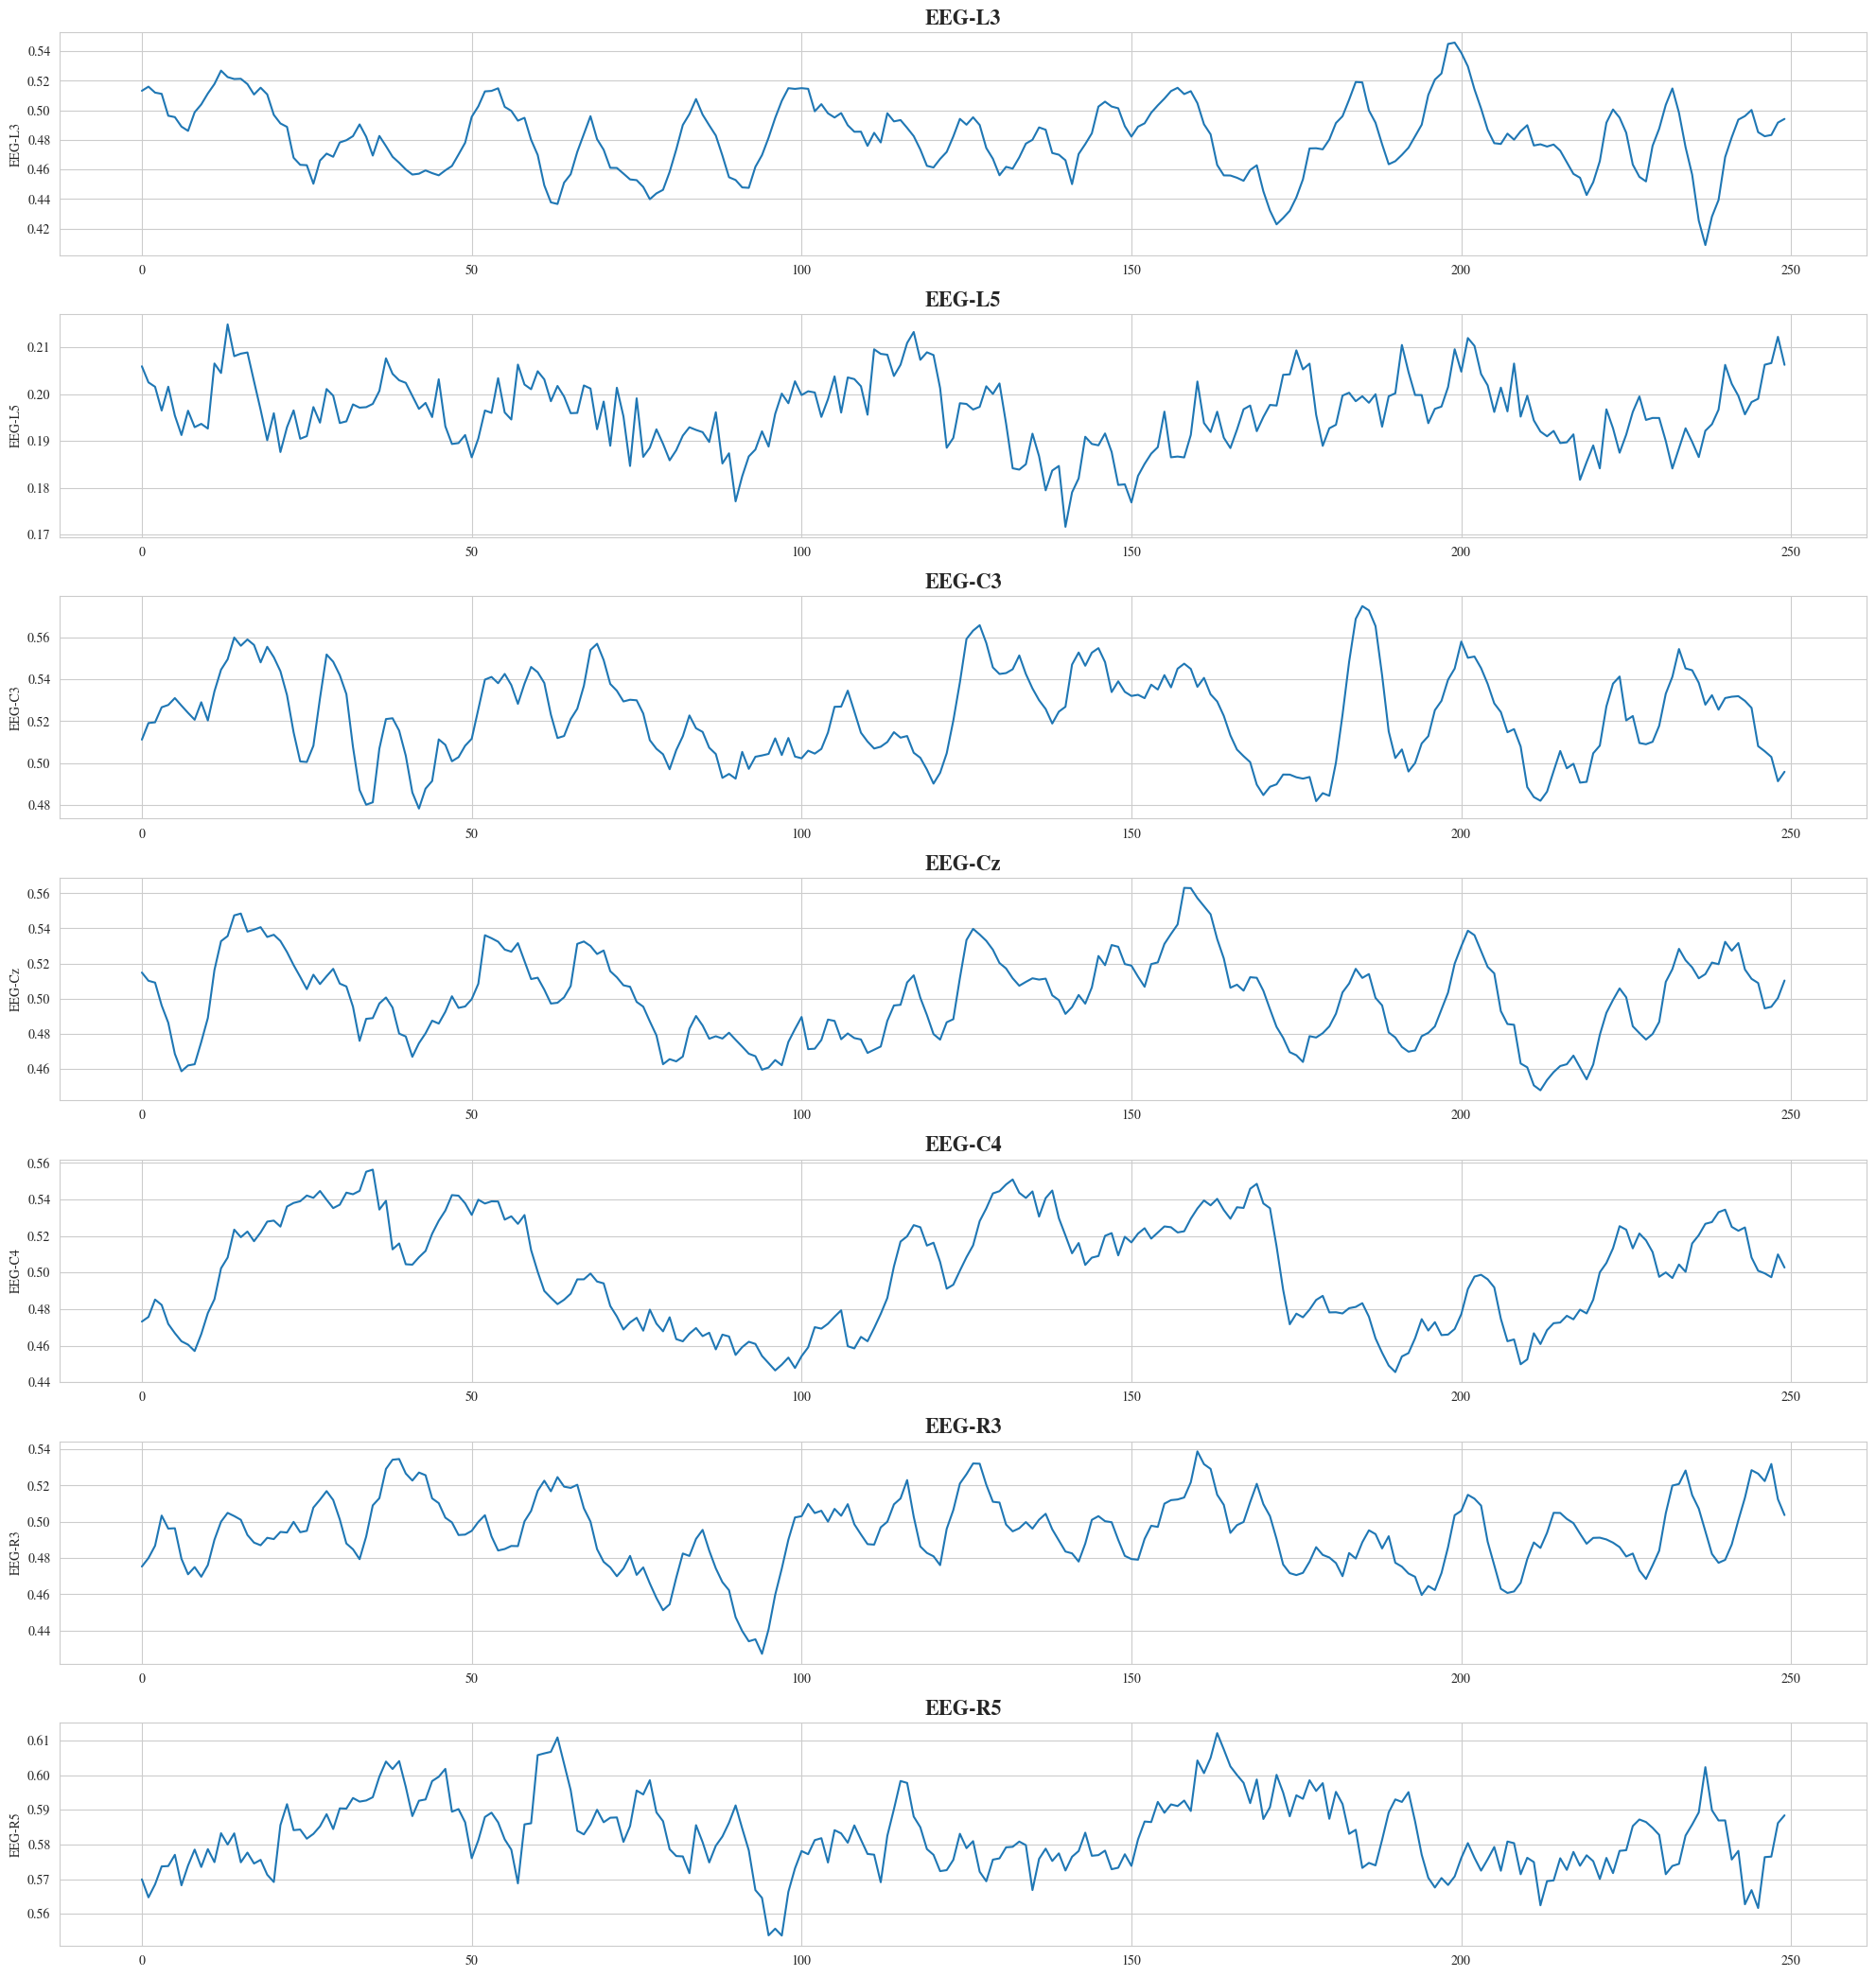

In [81]:
def plot_all_time_series(X: np.array) -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param x: np.array -- Input data of shape (N_SEQ, N_FEATS)
    :param time_col: str -- Name of the time column
    :return: None
    """
    df = pd.DataFrame(X, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(20, len(df.columns)*3))
    for col, ax in zip(df.columns, axes.flatten()):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

plot_all_time_series(synthetic_time_series[0])

# Visualize latent space / posterior
$$ q_\Phi(z|x) \approx p\theta(z|x) $$

In [82]:
def encode_batch(x: np.array):
    z_mean, z_log_var, z = vae.encoder(x)
    return z_mean, z_log_var, z

z_mean, z_log_var, z = encode_batch(tensor)

In [83]:
from sklearn.manifold import TSNE

In [84]:
tsne = TSNE(perplexity=10)
z_dim_reduced = tsne.fit_transform(z_mean)

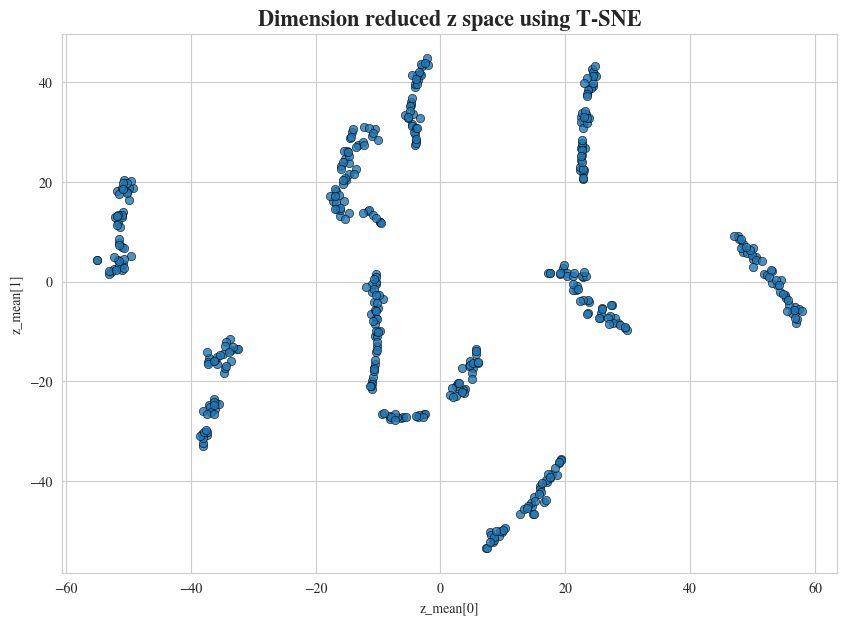

In [85]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title("Dimension reduced z space using T-SNE", fontweight="bold", size=16)
sns.scatterplot(x=z_dim_reduced[:,0], y=z_dim_reduced[:,1], ax=ax, edgecolor="black", alpha=.8)
ax.set_xlabel("z_mean[0]")
ax.set_ylabel("z_mean[1]")
fig.show()

# Visualize using PCA

In [86]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

N_PCS: int = 2
N_CLUSTERS: int = 3
    
pca = PCA(n_components=N_PCS, random_state=42)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)

In [87]:
z_dim_reduced_pca = pca.fit_transform(z_mean)
labels = kmeans.fit(z_mean).labels_

In [88]:
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")
pca.explained_variance_ratio_

Total Explained Variance: 1.00


array([0.98643002, 0.0105514 ])

In [89]:
centroids = pca.transform(kmeans.cluster_centers_)
centroids

array([[-1.08542435,  0.02435209],
       [-0.02075685, -0.03316678],
       [ 1.14769491,  0.07514825]])

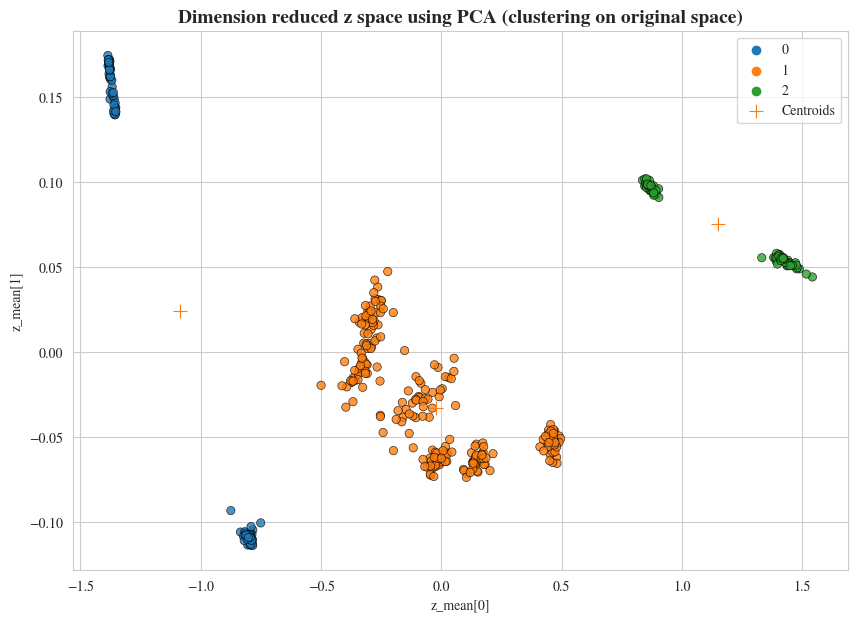

In [90]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title("Dimension reduced z space using PCA (clustering on original space)", fontweight="bold", size=14)
sns.scatterplot(x=z_dim_reduced_pca[:,0], y=z_dim_reduced_pca[:,1], ax=ax, edgecolor="black", alpha=.8, hue=labels, palette="tab10")
sns.scatterplot(x=centroids[:,0], y=centroids[:, 1], marker="+", label="Centroids", s=100, edgecolor="black")
ax.set_xlabel("z_mean[0]")
ax.set_ylabel("z_mean[1]")
fig.show()

In [91]:
# Pick a Sample and recounstruct
sample_z_mean = np.array([[0, 0]])
sample_z_mean = pca.inverse_transform(sample_z_mean)

In [92]:
sample_z_mean_reconstructed = vae.decoder(sample_z_mean)

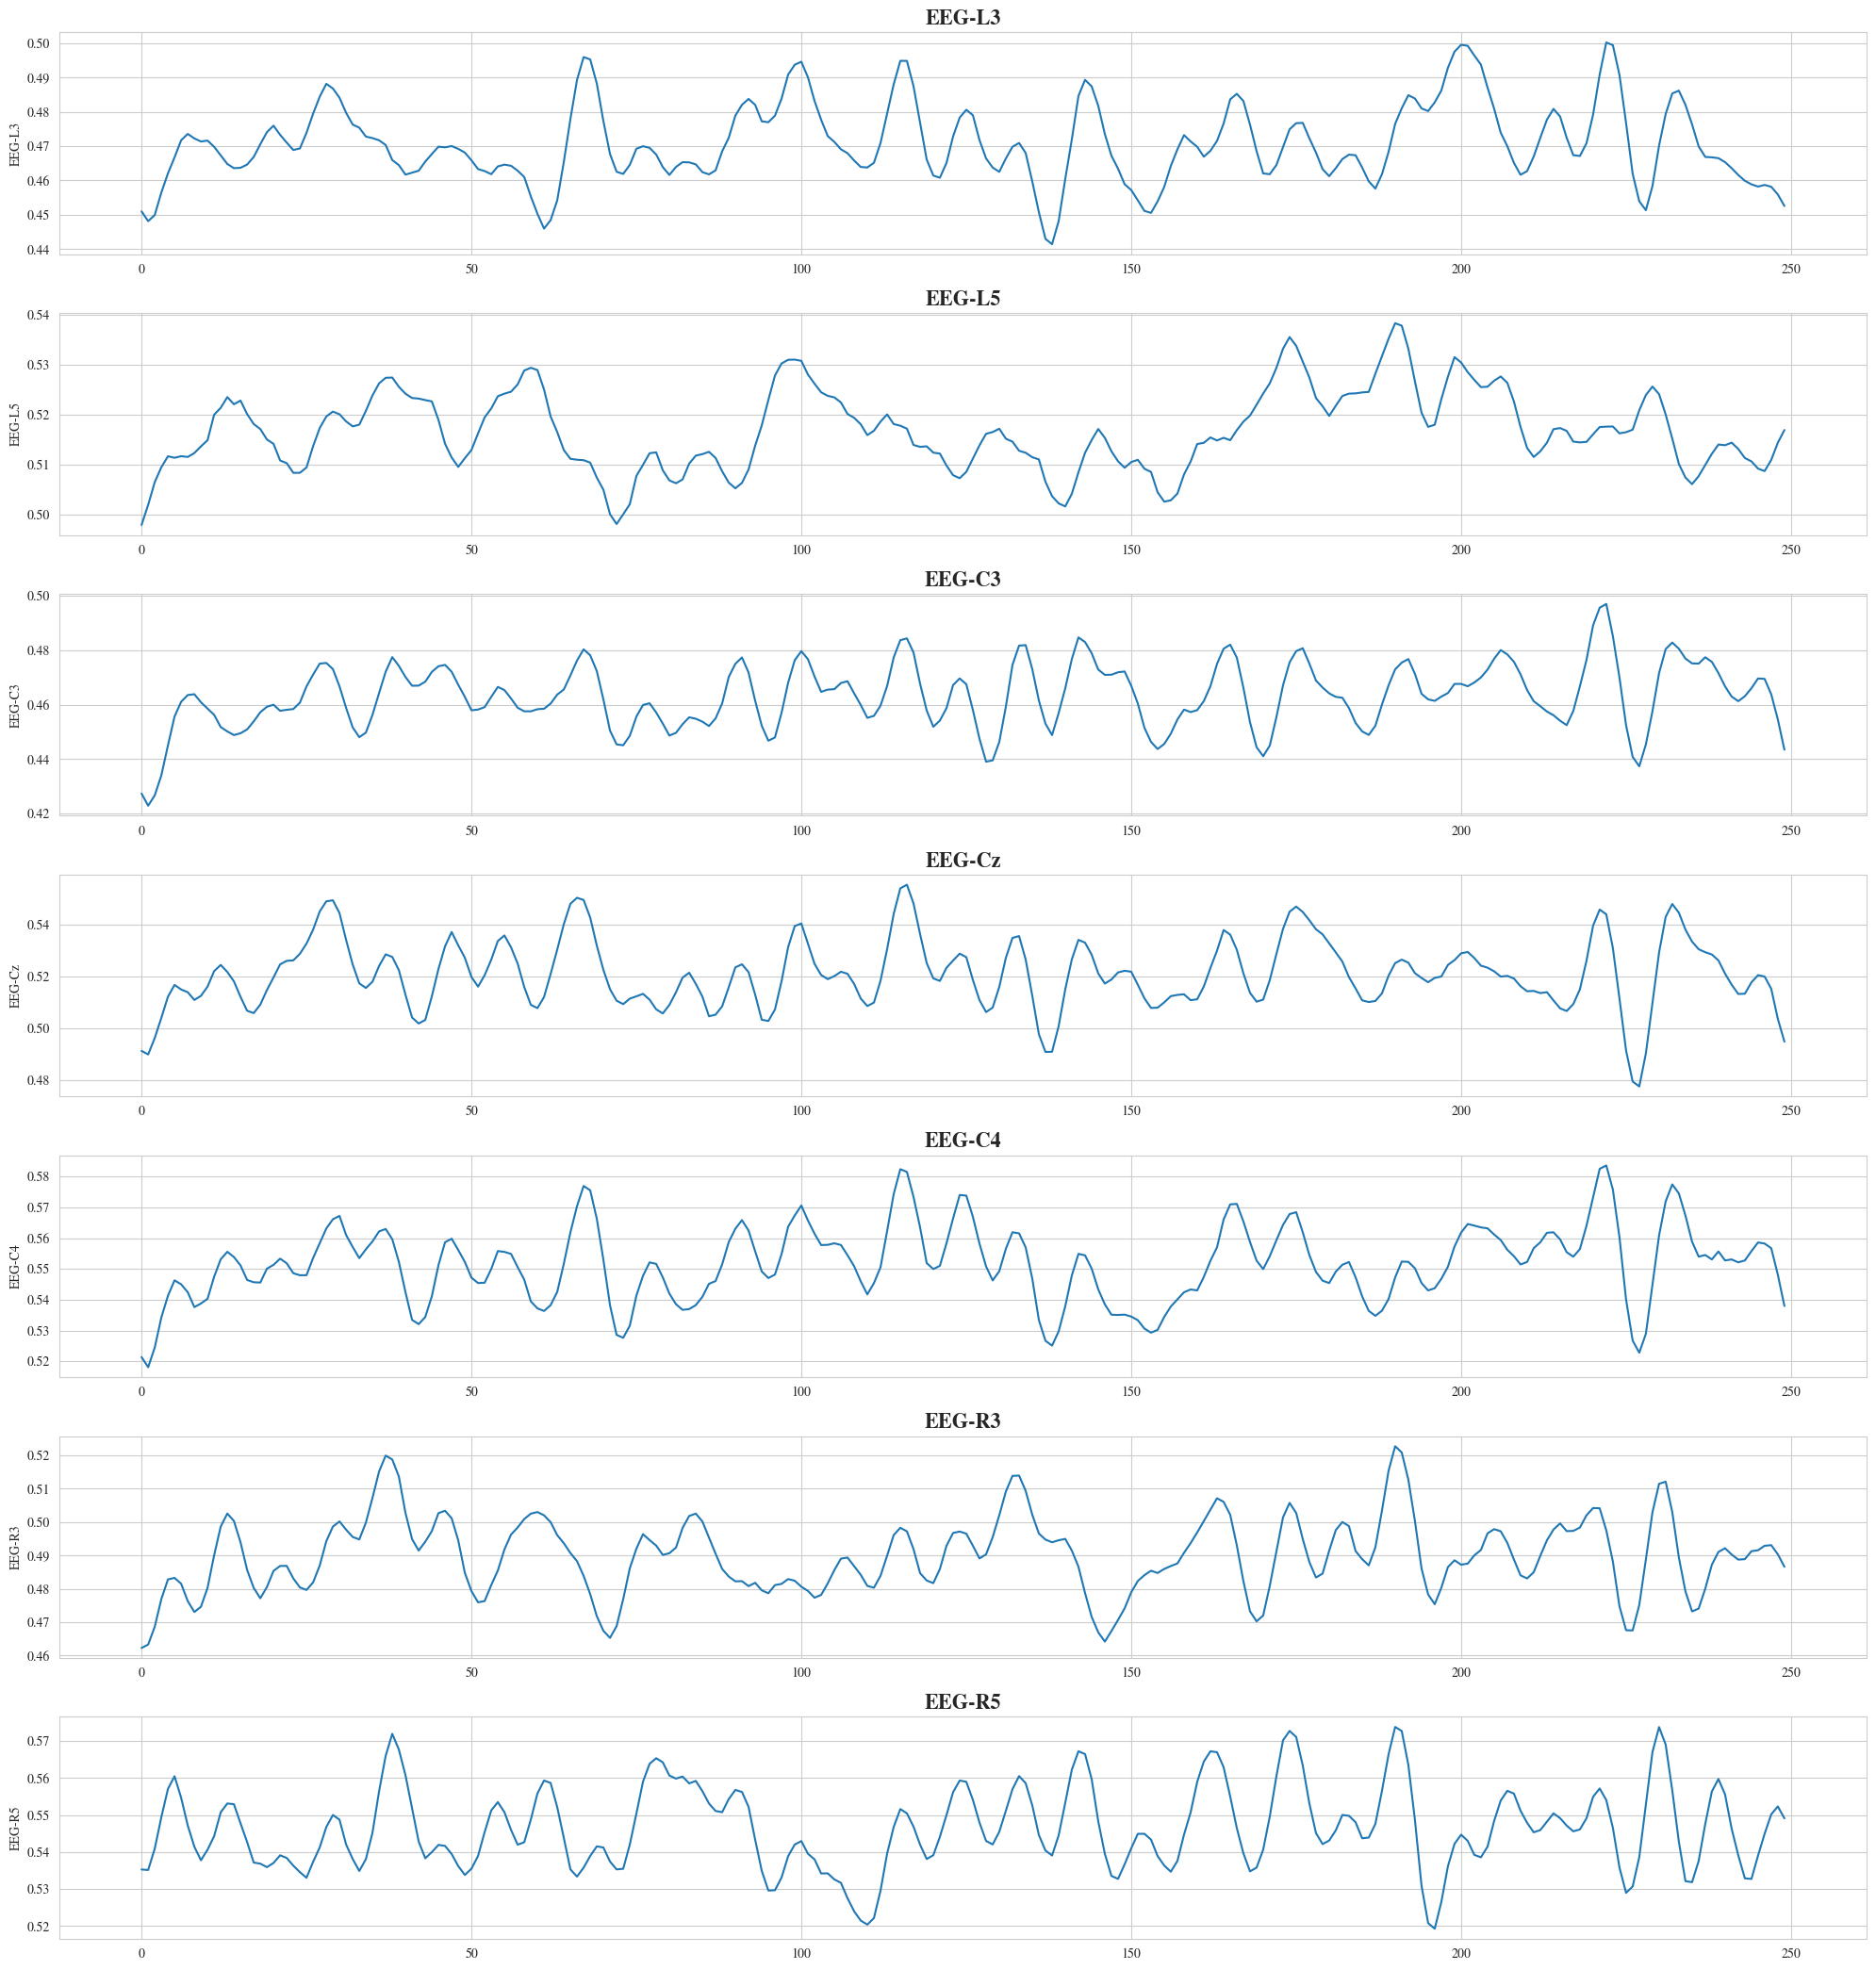

In [93]:
plot_all_time_series(sample_z_mean_reconstructed[0])

# Visualize Clusters

In [94]:
centroid_reconstructed = pca.inverse_transform(centroids)

In [95]:
samples_from_centroids = vae.decoder(centroid_reconstructed)

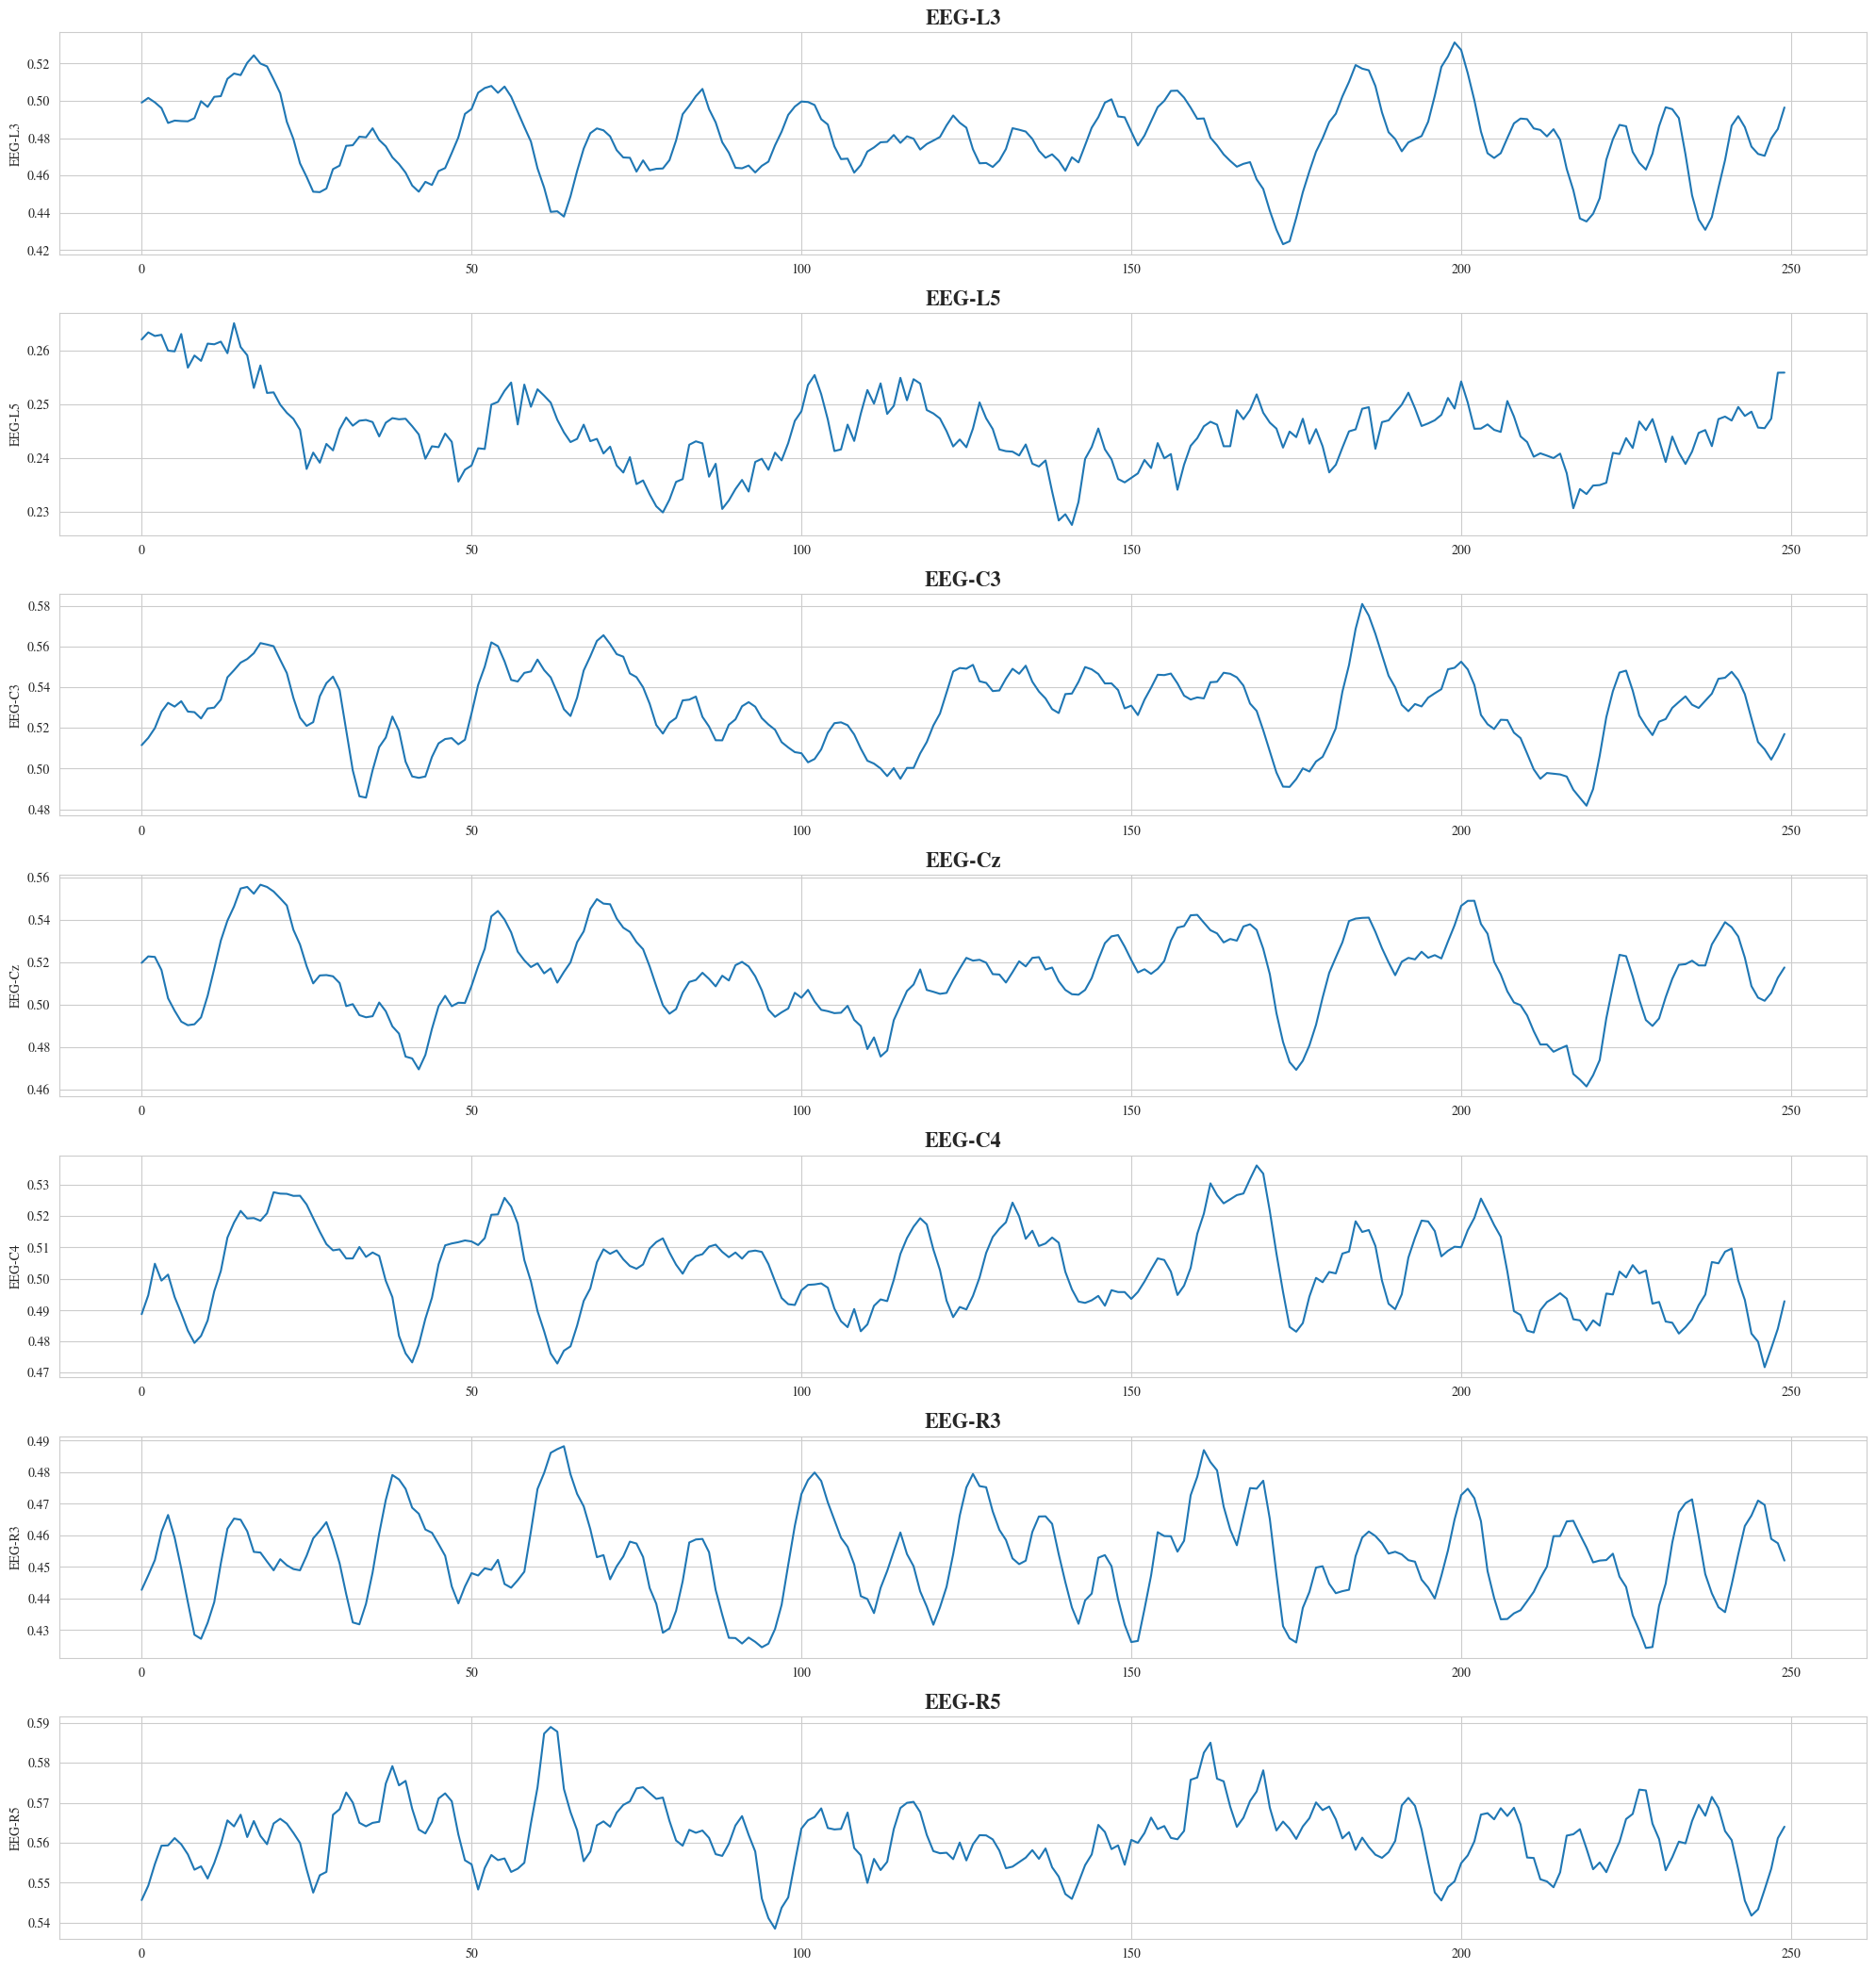

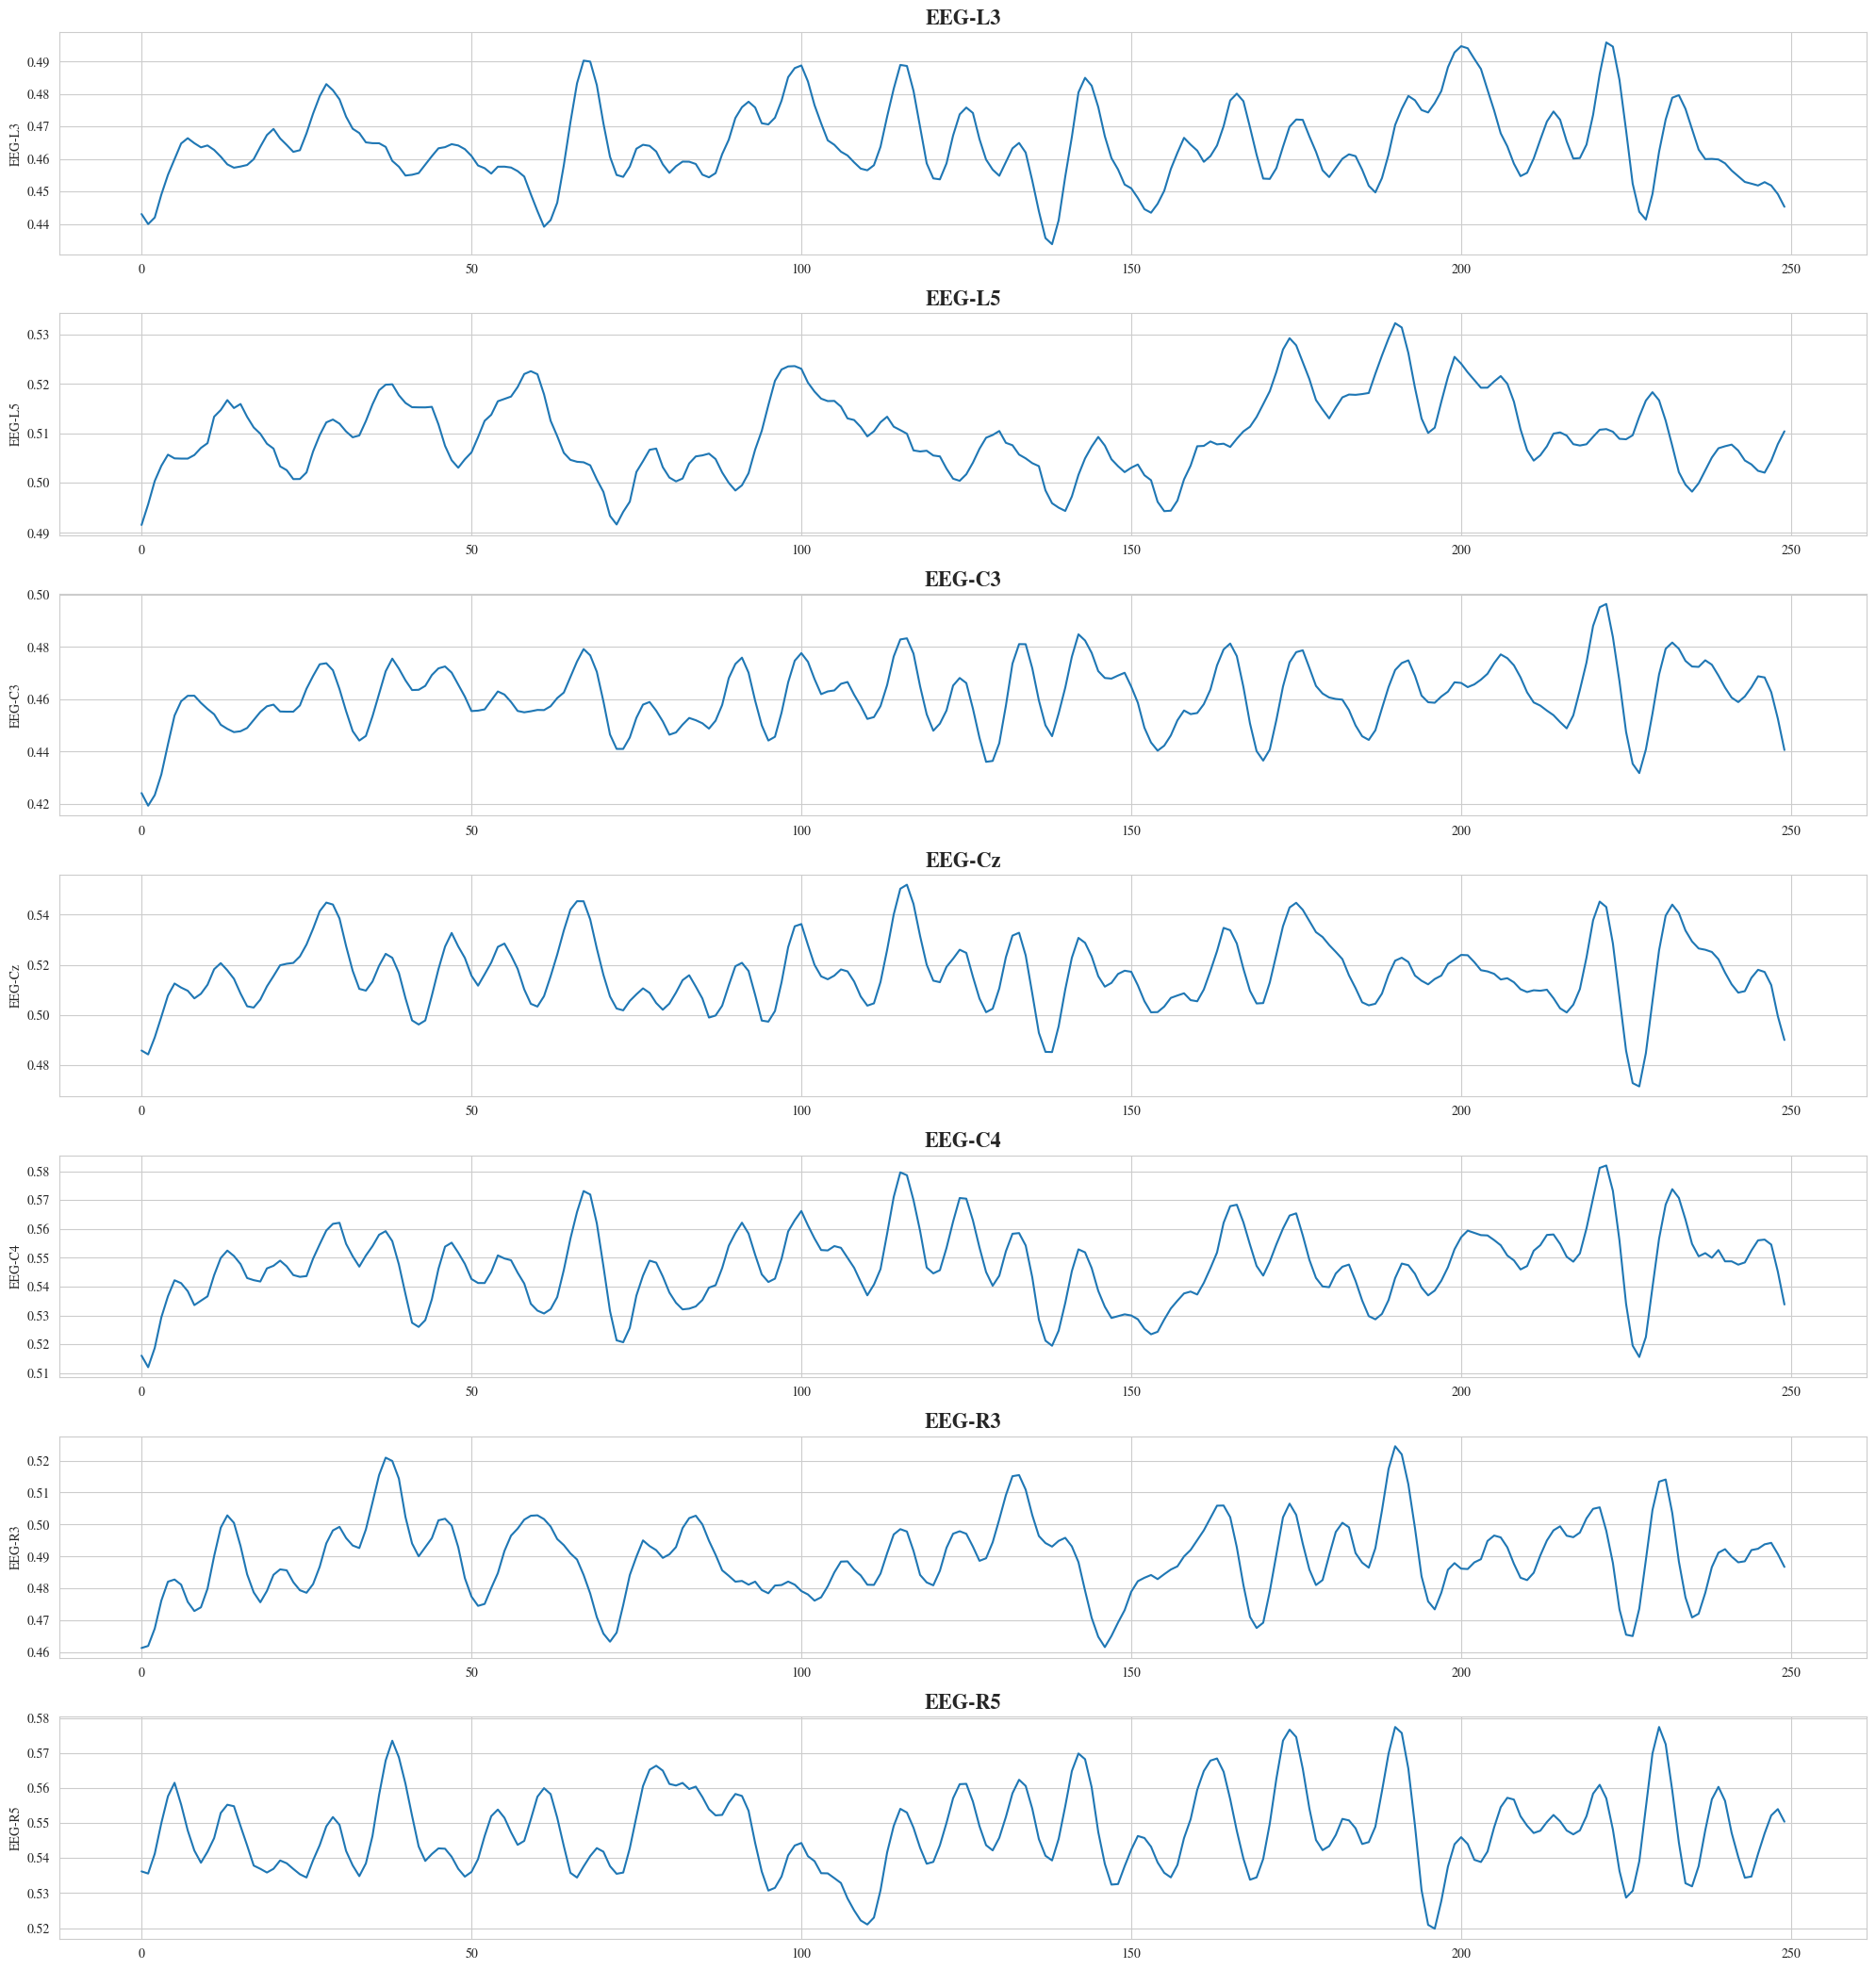

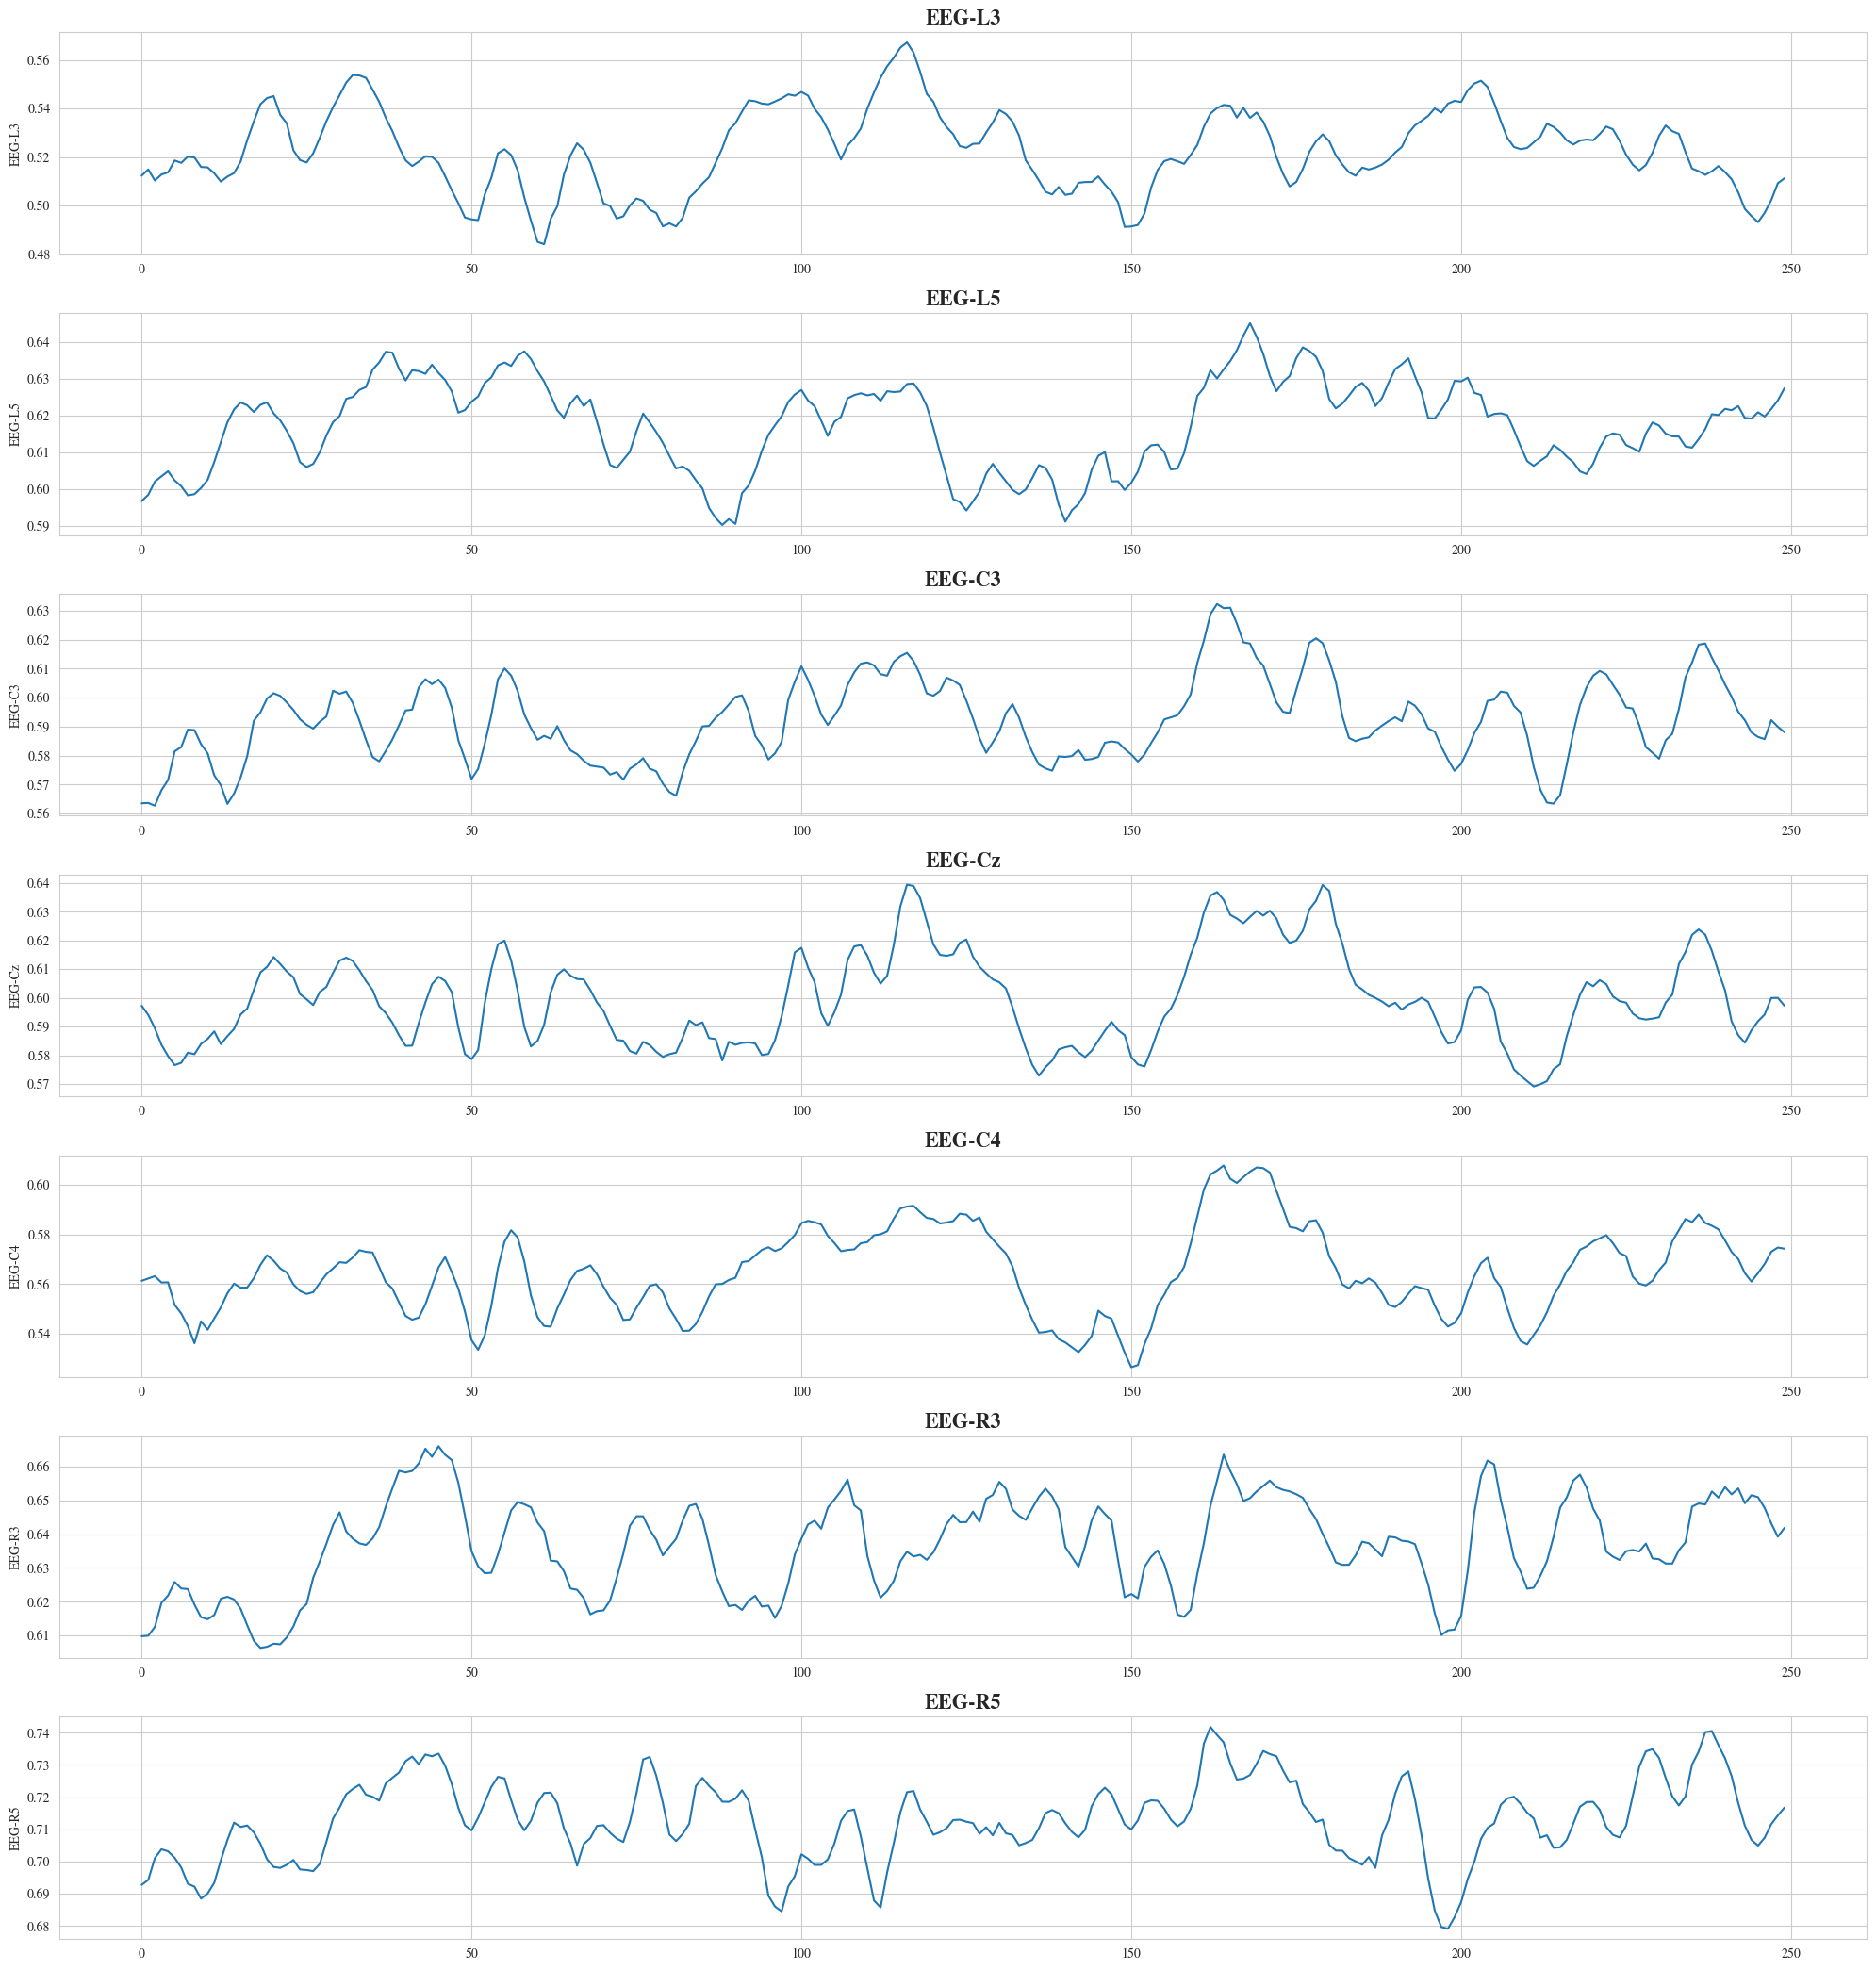

In [96]:
for i in range(samples_from_centroids.shape[0]):
    plot_all_time_series(samples_from_centroids[i])